<a href="https://colab.research.google.com/github/Sandipriz/EnvDatSci22/blob/master/CodeSprints/Solution_Regression101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 1: Extract Raster Values at Point Locations in Python
#### By Leah Wasser, Chris Holdgraf, Carson Farmer
Here, you will extract pixel values that cover each field plot area where trees were measured in the NEON Field Sites. The idea is that you can calculate the mean or max height value for all pixels that fall in each NEON site.

Then, you will compare that mean or max height value derived from the lidar data derived canopy height model pixels to height values calculated using human tree height measurements.

To do this, you need to do the following:

1. Import the canopy height model that you wish to extra tree height data from.
2. Clean up that data. For instance if there are values of 0 for areas where there are no trees they will impact a mean value calculation. It is better to remove those values from the data.
3. Finally you will import and create a buffer zone that represents the area where trees were sampled in each NEON field site.
To begin, import your python libraries.

https://www.earthdatascience.org/courses/use-data-open-source-python/spatial-data-applications/lidar-remote-sensing-uncertainty/extract-data-from-raster/

In [1]:
#attach to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rasterio
!pip install geopandas
!pip install seaborn
!pip install rioxarray
!pip install rasterstats
!pip install earthpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.6 MB/s 
     |████████████████████████████████| 16.7 MB 100 kB/s 
     |████████████████████████████████| 6.3 MB 43.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 2.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54611 sha256=87f25496892dce21216691f9e4a0e33e0eb63f13de0c137545a83d16606c263a
  Stored in directory: /root/.cache

In [3]:
import os
import matplotlib.pyplot as plt
from math import *
import numpy as np
import numpy.ma as ma
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
import seaborn as sns
import rioxarray as rxr

# Rasterstats contains the zonalstatistics function 
# that you will use to extract raster values
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep

# Set consistent plotting style
sns.set_style("white")
sns.set(font_scale=1.5)

# Download data and set working directory 
data = et.data.get_data("spatial-vector-lidar")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

Extracted output to /root/earth-analytics/data/spatial-vector-lidar/.


# PART 1: Analysis Ready Data
Our ability to directly sample many environmnetal processes on the ground is inherently limited. Often we need to be able to fill in the gaps between our sampled times/locations, predict values in places/times where it is unfeasible or impossible to sample, or characterize drivers of variability at spatiotemporal scales that aren't well represented by our *in-situ* data. 

Because of this, as the availability of global earth observations increases, it is increasingly common to combine georeferenced ground-based observations of an environmental process with global earth observations for supervised learning. In these workflows, ground-based observations often serves as the label or *predictand*, and global earth obserations serve as the *predictors*. A single dataset is then generated that presents contemporaneous values of predictand and predictors in a format that can serve as input to a statistical modelling software. This is called the **analysis ready dataset**. A classification or regression model is then trained to predict values of predictand at unsampled locations. 

With spatiotemporal data, generating the analysis ready dataset often involves a few common GIS operations, including:

* CRS conversions: getting all datasets into a common coordinate reference system to ensure accurate spatial overlap and minimal areal distortion over the area of interest (AOI).
* Spatial resampling: using basic interpolation to convert a raster dataset to finer (downsampling) or coarser (upsampling) spatial resolution so that pixels will overlap with another raster.
* Spatial and/or data mergers: combining all predictors and predictands as either rows in a dataframe or layers of an array, with individual cells/rows corresponding to unique spatiotemporal records.

Once all variables are organized into a dataframe or array, with each row/cell associated with a geographic entity (spatial vector or affine), additional data processing can occur using standard data processing software. Such steps include:
* Processing of no-data values: missing observations in individual variables are either gap filled or assigned an appropriate no-data value, based on the statistical model and modelling objectives.
* Feature reduction: creating a subset of meaningful predictors using domain expertise (feature engineering) or data compression (factor reduction).
* Data standardization: translating all variables into a standardized unit scale that maintains key features of the variables' marginal distribution (calculating the z-score, standardizing between 0 and 1).

The requisite data format and processing will be determined by the type of statistical model and statistical software/package that will be used.

Here, we will create an analysis ready dataset that combines tree canopy height measurements (predictand) with estimates of canopy height from an aircraft-based LiDAR dataset (predictor). In the second part of this code sprint, we will use our analysis ready dataset to train a linear regression model. This linear regression model will be used to diangose the accuracy of our LiDAR-based canopy height model.



#### Import Canopy Height Model
First, you will import a canopy height model created by the National Ecological Observatory Network (NEON). This canopy height model by subtracting the Digital elevation model (DEM) from the Digital surface model (DSM).

#### Context Managers and Rasterio
As you learned in the previous raster lessons, you will use a context manager with to create a connection to your raster dataset. This connection will be automatically closed at the end of the with statement.

In [4]:
# Load & plot the data
sjer_lidar_chm_path = os.path.join("data",
                                   "spatial-vector-lidar",
                                   "california", 
                                   "neon-sjer-site",
                                   "2013", 
                                   "lidar", 
                                   "SJER_lidarCHM.tif")

sjer_chm_data = rxr.open_rasterio(sjer_lidar_chm_path, masked=True).squeeze()



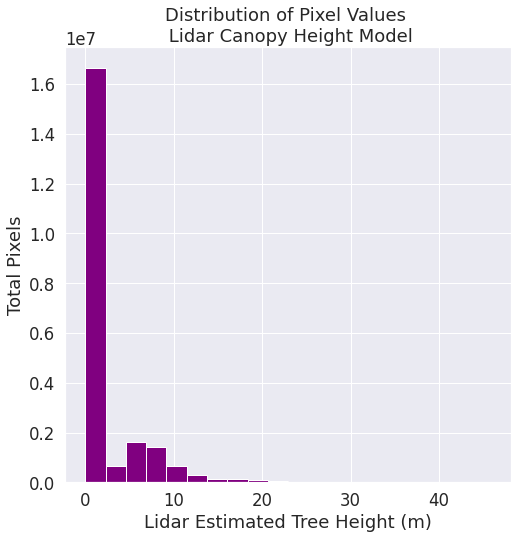

In [8]:
# Explore the data by plotting a histogram with earthpy
ax=ep.hist(sjer_chm_data.values,
        figsize=(8,8),
        colors="purple",
        xlabel="Lidar Estimated Tree Height (m)",
        ylabel="Total Pixels",
        title="Distribution of Pixel Values \n Lidar Canopy Height Model")

# Turn off scientific notation
#ax[1].ticklabel_format(useOffset=False,
                    #style='plain')

In [16]:
# EXPLORE: View summary statistics of canopy height model
sjer_chm_data.head(3)
# Notice the mean value with 0's included in the data
print('Mean:', sjer_chm_data.mean().values)
print('Max:', sjer_chm_data.max().values)
print('Min:', sjer_chm_data.min().values)

<xarray.DataArray (y: 3, x: 3)>
array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 2.546e+05 2.546e+05 2.546e+05
  * y            (y) float64 4.112e+06 4.112e+06 4.112e+06
    spatial_ref  int64 0
Attributes:
    STATISTICS_MAXIMUM:  45.879997253418
    STATISTICS_MEAN:     1.#SNAN
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   1.#SNAN
    scale_factor:        1.0
    add_offset:          0.0

In [18]:
# Plot model
ep.plot_bands(sjer_chm_data,
              title="Lidar Estimated Tree Height (m)",
              cmap="Greys")

plt.show()

SyntaxError: ignored

In [20]:
type(sjer_chm_data)

xarray.core.dataarray.DataArray

### TASK 1: What type of object is the sjer_chm_data? How does it differ from the raster layer we read in using rasterior? Why did I refer to this dataset as a model?

### Clean Up Data - Remove 0’s
Looking at the distribution of data, you can see there are many pixels that have a value of 0 - where there are no trees. Also, using the NEON data, values below 2m are normally set to 0 given the accuracy of the lidar instrument used to collect these data.

Set all pixel values ==0 to nan as they will impact calculation of plot mean height. A mean calculated with values of 0 will be significantly lower than a mean calculated with just tree height values.

### TASK 2: Create mask that converts zero values to np.nan (no data or not a number). Replot the summary statistics (mean, min, and max). Plot the histogram again. What happend?

In [ ]:
# Task 2: mask data using rioxarray
sjer_chm_data_no_zeros = sjer_chm_data.where(sjer_chm_data != 0, np.nan)

# Task 2: view summary statistics of canopy height model after cleaning up the data


In [ ]:
# Task 2: view histogram of canopy height model after cleaning up the data


#### Import Plot Location Data & Create Buffer
You now have a cleaned canopy height model for your study area in California. However, how do the height values extracted from the CHM compare to our manually collected, field measured canopy height data? To figure this out, you will use in situ collected tree height data, measured within circular plots across our study area. You will compare the maximum measured tree height value to the maximum LiDAR derived height value for each circular plot using regression.

First, import the shapefile that contains the plot centroid (the center point of each plot) locations using geopandas.

In [ ]:
sjer_centroids_path = os.path.join("data", "spatial-vector-lidar", 
                                   "california", "neon-sjer-site", 
                                   "vector_data", "SJER_plot_centroids.shp")

SJER_plots_points = gpd.read_file(sjer_centroids_path)

type(SJER_plots_points)

#### Overlay Points on Top Of Your Raster Data
Finally, a quick plot allows you to check that your points actually overlay on top of the canopy height model. This is a good sanity check just to ensure your data actually line up and are for the same location.

If you recall in week 2, we discussed the spatial extent of a raster. Here is where you will need to set the spatial extent when plotting raster using imshow(). If you do not specify a spatial extent, your raster will not line up properly with your geopandas object.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# We plot with the zeros in the data so the CHM can be better represented visually
ep.plot_bands(sjer_chm_data,
              extent=plotting_extent(sjer_chm_data,
                                     sjer_chm_data.rio.transform()),  # Set spatial extent
              cmap='Greys',
              title="San Joachin Field Site \n Vegetation Plot Locations",
              scale=False,
              ax=ax)

SJER_plots_points.plot(ax=ax,
                       marker='s',
                       markersize=45,
                       color='purple')
ax.set_axis_off()
plt.show()


### TASK 3: In your own words, caption this plot. What does the color scale represent? What do the purple points represent?

*Type plot caption here*

### Create A Buffer Around Each Plot Point Location
Each point in your data represent a point where tree height was measured on the ground. This height value is representative of the entire tree canopy, which will extend beyond the point. You want to extract tree height values derived from the LiDAR data for the entire tree canopy. To do this, you will need to create a BUFFER around the point representing the crown of the tree.

In this case, we assume that individual trees have a canopy that is 40m in diameter. If you create a circular buffer with a 20m diameter, you will generate a polygon that approximates the area occupied by the tree canopy. 

You can use the .buffer() method to create this polygon. Here the buffer size is specified in the () of the function. You will send the new object to a new shapefile using .to_file(). 

In the next cells, you will:

1. Make a copy of the points layer that will become a new polygon layer.
2. Buffer the points layer using the .buffer() method. This will produce a circle around each point that is x units radius. The units will coincide with the CRS of your data. This is known as a buffer.
3. When you perform the buffer, you UPDATE the “geometry” column of your new poly layer with the buffer output.


In [ ]:
# Create a buffered polygon layer from your plot location points
SJER_plots_poly = SJER_plots_points.copy()

# Buffer each point using a 20 meter circle radius 
# and replace the point geometry with the new buffered geometry
SJER_plots_poly["geometry"] = SJER_plots_points.geometry.buffer(20)
SJER_plots_poly.head()

### TASK 4: Plot SJER_plots_poly over the canopy model. What type of spatial file is SJER_plots_poly? Did we make this file or did we read it in from the internet? What does SJER_plots_poly represent?

In [ ]:
#Task 4: Plot SJER_plots_poly over the canopy model


Finally, export the buffered layer as a new shapefile. You will use this layer when you use the zonalstats function. Below you first check to ensure the outputs directory exists that you wish to write your data to. Then you export the data using the to_file method.

In [ ]:
# If the dir does not exist, create it
output_path = os.path.join("data", "spatial-vector-lidar", "outputs")

if not os.path.isdir(output_path):
    os.mkdir(output_path)

# Export the buffered point layer as a shapefile to use in zonal stats
plot_buffer_path = os.path.join(output_path, "plot_buffer.shp")
SJER_plots_poly.to_file(plot_buffer_path)

### Extract Pixel Values For Each Plot
Once you have the boundary for each plot location (a 20m diameter circle) you can extract all of the pixels that fall within each circle using the function zonal_stats in the rasterstats library.


#### There are several ways to use the zonal_stats function. In this case we are providing the following

1. chm data (numpy array): SJER_chm_data in a numpy array format. Because a numpy array has no spatial information, you provide the affine data which is the spatial information needed to spatially located the array.
2. plot_buffer_path: this is the path to the buffered point shapefile that you created at the top of this lesson

Calculating zonal statistics is often a very important component of creating analysis-ready datasets for supervised machine learning operations using raster data. Learn more here:

https://pythonhosted.org/rasterstats/manual.html 

In [ ]:
# Extract zonal stats
sjer_tree_heights = rs.zonal_stats(plot_buffer_path,
                                   sjer_chm_data_no_zeros.values,
                                   nodata=-999,
                                   affine=sjer_chm_data_no_zeros.rio.transform(),
                                   geojson_out=True,
                                   copy_properties=True,
                                   stats="count min mean max median")

# View object type
type(sjer_tree_heights)

### TASK5: Open the rasterstats manual linked above. What does the "affine" argument in rs.zonal_stats accomplish? Why do we use it?

### Analysis-ready data from maps
Analysis-ready data is ready to be input directly into a statistical software for processing. If your statistical software is Microsoft Excel, for example, your analysis ready dataset would be an Excel spreadsheet. We will be mainly using statistical analysis packages written in Python in this class, and our analysis ready datasets will generally either be numpy arrays or pandas dataframes.  

In [ ]:
# Turn extracted data into a pandas geodataframe
SJER_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_tree_heights)
SJER_lidar_height_df.head()

#### Below is a bar plot of max lidar derived tree height by plot id. This plot allows you to see how vegetation height varies across the field sites.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(SJER_lidar_height_df['Plot_ID'],
       SJER_lidar_height_df['max'],
       color="purple")

ax.set(xlabel='Plot ID', ylabel='Max Height',
       title='Maximum LIDAR Derived Tree Heights')

plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

## Part 2: Use Regression Analysis to Explore Data Relationships & Bad Data
### by Max Joseph, Leah Wasser

### https://www.earthdatascience.org/courses/use-data-open-source-python/spatial-data-applications/lidar-remote-sensing-uncertainty/compare-lidar-and-measured-tree-height-regression/


### Learning Objectives
1. Perform a basic least squares linear regression analysis on two variables of interest in Python.
2. Analyze regression outputs to determine the strength of the relatonship between two variables.
3. Define R-squared and p-value as it relates to regression.

### In this lesson, you will learn you will learn the basic fundamentals of creating a linear regression model between the two variables.

### Quantifying Relationships Between Variables: What Is A One to One Line?
A one-to-one line is a line that represents what the relationship between two variables would be if their values were equal. For example, if lidar and ground measurements of tree height were always equal, then observations of height would fall on the one to one line in a scatterplot.

See the example below.

In [ ]:
# Setting consistent plotting style throughout notebook
sns.set_style("white")
sns.set(font_scale=1.5)

# Download data and set working directory
data = et.data.get_data("spatial-vector-lidar")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [ ]:
lidar_path = os.path.join("data", "spatial-vector-lidar", 
                          "california", "neon-sjer-site", 
                          "2013", "lidar", "SJER_lidarCHM.tif")

with rio.open(lidar_path) as lidar_chm_src:
    SJER_chm_data = lidar_chm_src.read(1, masked=True)
    SJER_chm_meta = lidar_chm_src.profile

In [ ]:
# Import plot locations and extract summary raster statistics
plot_buffer_path = os.path.join("data", "spatial-vector-lidar", 
                                "outputs", "plot_buffer.shp")

sjer_tree_heights = rs.zonal_stats(plot_buffer_path,
                                   SJER_chm_data,
                                   affine=SJER_chm_meta['transform'],
                                   geojson_out=True,
                                   copy_properties=True,
                                   stats="mean max")



SJER_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_tree_heights)



In [ ]:
# Import in situ data
path_insitu = os.path.join("data", "spatial-vector-lidar", 
                           "california", "neon-sjer-site", 
                           "2013", "insitu", 
                           "veg_structure/D17_2013_SJER_vegStr.csv")

SJER_insitu = pd.read_csv(path_insitu)


# Get the max and mean stem height for each plot
insitu_stem_ht = SJER_insitu.groupby('plotid', as_index=False)
insitu_stem_ht = insitu_stem_ht['stemheight'].agg(['max', 'mean'])
insitu_stem_ht = insitu_stem_ht.rename(
    columns={'max': 'insitu_maxht', 'mean': 'insitu_meanht'})
insitu_stem_ht.reset_index(inplace=True)

# First rename columns so that we know which belongs to lidar
SJER_lidar_height_df = SJER_lidar_height_df.rename(
    columns={'max': 'lidar_max', 'mean': 'lidar_mean', 'min': 'lidar_min'})

# Join the data
SJER_final_height = SJER_lidar_height_df.merge(insitu_stem_ht,
                                               left_on='Plot_ID',
                                               right_on='plotid')
# Convert to a dataframe so we can use standard pandas plotting
SJER_final_height_df = pd.DataFrame(SJER_final_height)

# Plot scatter plot
fig, ax = plt.subplots(figsize=(10, 10))

#csfont = {'fontname':'Myriad Pro'}
SJER_final_height_df.plot('lidar_max', 'insitu_maxht',
                          kind='scatter', color="purple",
                          s=60, ax=ax)

# Add a diagonal line
ax.set(xlim=[0, 30], ylim=[0, 30], label="Data")
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',
        c='k', label="1:1 line")

ax.set(xlabel="Lidar derived max tree height (m)",
       ylabel="Measured tree height (m)", title="Lidar vs Measured Tree Height - SJER")

In practice, observations from different methods rarely show a 1:1 relationship. For example above, you can see how lidar estimates compare to human made measurements of tree height. Notice that some measurements are similar, and close to the 1:1 line. In other cases, when points lie above or below the 1:1 line, the measurements are different.

This all assumes that you decide that the human measurement is correct all of the time. But you know from discussions about uncertainty and from being a human yourself, that often times, humans make mistakes too! Some people may think that, particularly in dense forests, lidar does an even better job of measuring the tallest trees that humans can not fully get a clear view of to make a measurement.

A 1:1 line is a start at comparing two sets of measurements. However, what if you want to predict one measurement from another? For example, given a measurement of lidar derived tree height, what would be the measured tree height on the ground?

Linear regression is a way to predict one measurement from another. It accounts for the fact that the linear relationship between the two variables might not be a one to one line, and that there may be variation in the data around the line.

## Linear regression requires two variables:

An independent variable (let’s call it x) and a dependent variable (let’s call it y)

Linear regression uses x to predict y by finding the “best fit” line between x and y, assuming the following model:

`y=a+bx+error`

Where:

a is an intercept

b is a slope

Conceptually “best fit” means finding the values of a and b that minimize the error (or difference between predicted and actual y). One measure of fit is R-squared. When R2 is close to one, the model fits well, and when R2 is close to zero, the model fits poorly.

You can run a regression analysis on the data above using the stats package in scipy.



In [ ]:
from scipy import stats
#Note: some of you may get an error from this import function. What do you do about it?

x = SJER_final_height_df.lidar_max
y = SJER_final_height_df.insitu_maxht

### TASK 6: What is the data type of the variable "x"? what is the data type of variable y?

In [ ]:
#Task 7:

In [ ]:
# Train a linear regression model using stats.linregress
slope, intercept, r_value, _, _ = stats.linregress(x, y)

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2)

### TASK 7: Name three other model options that are available through the scipi stats library in Python.

In [ ]:
#Task 8:

### Translating the Output of the Linear Regression Model
#### Intercept 2.98: 
Here our intercept is close to 3. This means that if the lidar derived height were 0, the estimated ground truth height would be close to 3, which may suggest some systematic offset between the lidar and ground measurements of height. But, we should be careful with this interpretation, because we did not have any lidar data with zero height measurements. Any conclusions we draw about such observations are extrapolations beyond the range of data that were observed.

#### Slope of .76: 
The slope is positive and while it’s not 1, it’s also not that far from 1 at .76. This is not terrible. This slope suggests that for a one meter increase in lidar derived height, we expect a 76 cm increase in ground truth height. This actually could make some sense if you think about how difficult it can be to measure tall trees manually. But how hard it might be for lidar systems to reflect off of shorter and potentially smaller trees

#### R squared of .69: 
This tells us that the linear regression model explains 69% of the variablility found in the data.

Overall with results like these we can conclude that lidar does a reasonable job of estimating tree height.

#### Plot Regression Fits Compared to 1:1
Look at a plot of the data below. You have both the 1:1 line and the regression model fit. Are they different? Think about what this output tells you.

In [ ]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 10))

m = slope.astype(float)

SJER_final_height_df.plot('lidar_max', 'insitu_maxht',
                          kind='scatter', color="purple",
                          s=60, ax=ax, label="Data")

# Add a diagonal line
ax.set(xlim=[0, 30], ylim=[0, 30])
ax.plot((0, 1), (0, 1), 'y-', transform=ax.transAxes, label="1:1 line")
ax.plot(x, m*x + intercept, 'grey', label='regression fitted line')

ax.set(xlabel="Lidar derived max tree height (m)",
       ylabel="Measured tree height (m)", title="Lidar vs Measured Tree Height - SJER")
plt.legend()

### Good Fit, Large Intercept
Sometimes the question you are asking is whether one variable is the same (or similar to) another variable. In this case a model that implies that there is a strong relationship between two variables may indicate that the variables do not necessarily measure the same thing. For example, a model with a strong R-squared value may have a large intercept. In this case you know there is a significant bias where your predictor might under or overestimate the variable of interest:

#### Example: Lidar has a very strong fit with human measurements but the slope is very small and the intercept is very large. See below:

In [ ]:
# Create some points with a one to one relationships
x = np.array([1, 22, 3, 14, 16, 45, 45])
y = np.array([item+10 for item in x])

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y, c='blue', label="data")

ax.plot((0, 1), (0, 1), transform=ax.transAxes,
        ls='--', c='k', label="1:1 line")

ax.plot(x, intercept + slope*x, 'grey', label='regression fitted line')

ax.set(xlim=[0, 50], ylim=[0, 50])

ax.set(xlabel="Variable A", ylabel="Variable B",
       title="Data Points with a Strong \nR-squared and P-value but not a 1:1")

plt.legend(fontsize=14)

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2,
      "\np-value:", p_value,
      "\nst_error", std_err,
      "\nRMSE", sqrt(std_err))

### Similarly maybe there is a positive bias in your predictor:

In [ ]:
# Create some points with a one to one relationships
x = np.array([1, 22, 3, 14, 16, 45, 45])
y = np.array([item-5 for item in x])

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)


fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y, c='blue', label="data")
ax.plot((0, 1), (0, 1), transform=ax.transAxes,
        ls='--', c='k', label="1:1 line")

ax.plot(x, intercept + slope*x, 'grey', label='regression fitted line')

ax.set(xlim=[0, 50], ylim=[0, 50])

ax.set(xlabel="Variable A", ylabel="Variable B",
       title="Data Points with a Strong \nR-squared but There is a Positive Bias")

plt.legend()

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2,
      "\np-value:", p_value,
      "\nst_error", std_err,
      "\nRMSE", sqrt(std_err))

Other Linear Regression Model Outputs
The ouputs of a linear regression model help you assess how statistically useful or significant the model is as compared to a hypothesis or theory that there is no relationship between the variables. If the data have no relationship, then the slope of the line is 0. In scientific terms this translates to whether you want to trust the model or not. These outputs includes:

Root Mean Squared Error (RMSE): RMSE is an overall measure of how far the y-values lie from the estimated line on average. You can think of it as on average, how far away from a 1:1 relationship are the predicted data. If lidar is predicting human measurements is it on average 1m taller, 2m shorter, etc? Technically defined, it’s defined as the square root of the variance of the residuals.

P-value: The p-value can be used to see how consistent the data are with the notion that the true slope of the line is zero (that there is no relationship between the variables of interest). A threshold of 0.05 is commonly used to determine whether there is sufficient evidence to reject the hypothesis that the true slope is zero. If p < 0.05, then one typically concludes the true slope is nonzero, though this threshold is arbitrary.

Note that to calculate the RMSE you take the squareroot of the standard error provided to you by Python.

In [ ]:
# Create some points with a one to one relationships
x = np.array([1, 22, 3, 14, 16, 45, 45])
y = np.array([item-5 for item in x])

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y, c='blue', label="data")

ax.plot((0, 1), (0, 1), transform=ax.transAxes,
        ls='--', c='k', label="1:1 line")

ax.plot(x, intercept + slope*x, 'grey', label='regression fitted line',
        color="purple")

ax.set(xlim=[0, 50], ylim=[0, 50])

ax.set(xlabel="Variable A", ylabel="Variable B",
       title="Data Points with a Strong \nR-squared but There is a Positive Bias")

plt.legend()

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2,
      "\np-value:", p_value,
      "\nst_error", std_err,
      "\nRMSE", sqrt(std_err))

### Use Seaborn To Plot Regression Fit
Below is a plot of the same data using the seaborn package. The Seaborn package wraps around Matplotlib. It makes it easier to make nice looking plots, quickly.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.regplot('lidar_max', 'insitu_maxht', data=SJER_final_height_df,
                 color="purple")

# Add a diagonal line
ax.set(xlim=[5, 30], ylim=[5, 30])
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--', c='k')

ax.set(xlabel="Lidar derived max tree height (m)",
       ylabel="Measured tree height (m)", title="Lidar vs Measured Tree Height - SJER")

### View Difference: Lidar vs. Measured
A non statistical approach to understand the relationship between these two variables is a plain old difference plot. Below you can identify which ground plots have the largest difference and which ones have the smallest. If you were working with these data, you might want to explore each individual plot to see if you can figure out why this relationship works better in some plots compared to others.

Below is the code for the challenege opportunity in the last lesson.

#### Can you think of any things that could occur in particular plots that may through off your data?

In [ ]:
# Calculate difference and add the plot id to each xaxis label
SJER_final_height["lidar_measured"] = SJER_final_height["lidar_max"] - \
    SJER_final_height["insitu_maxht"]

fig, ax = plt.subplots(figsize=(12, 7))

ax.bar(SJER_final_height['plotid'], SJER_final_height['lidar_measured'],
       color="purple")

ax.set(xlabel='Plot ID', ylabel='(Lidar - Measured) Height Difference (m)',
       title='Difference Between lidar and Measured Tree Height')

plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()